# MLP Train

### 1.package

In [1]:
import torch
import h5py
import numpy as np
from obspy import read
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

### 2.load data

#### lst to hdf5

In [12]:
# 获取时间窗（P波和S波到达时间）
def get_window_times(Z_hdr):
    before_sec = 0.25
    after_sec = 1.85
    a = Z_hdr.get('a', None)
    t0 = Z_hdr.get('t0', None)
    
    if a is not None and t0 is not None:
        t_p = a  # P波到达时间
        t_s = t0  # S波到达时间
    elif Z_hdr.t3 > 0 and Z_hdr.t4 > 0:
        t_p = Z_hdr.t3  # P波到达时间
        t_s = Z_hdr.t4  # S波到达时间
    elif a is not None and Z_hdr.t4 > 0:
        t_p = a  # P波到达时间
        t_s = Z_hdr.t4  # S波到达时间
    elif Z_hdr.t3 > 0 and t0 is not None:
        t_p = Z_hdr.t3  # P波到达时间
        t_s = t0  # S波到达时间
    else:
        raise ValueError("没有找到有效的P波或S波到达时间。")
    
    # 根据P波或S波确定时间窗
    if Z_hdr.kcmpnm == 'HHZ':  # Z分量
        start_time = int((t_p - before_sec) / Z_hdr.delta)
        end_time = int((t_p + after_sec) / Z_hdr.delta)
    else:  # T分量
        start_time = int((t_s - before_sec) / Z_hdr.delta)
        end_time = int((t_s + after_sec) / Z_hdr.delta)

    return start_time, end_time

# 震级转换为M0
def compute_M0(magnitude):
    Mw = 0.754 * magnitude + 0.88  # Mw ML转换
    return 10 ** (1.5 * Mw + 9.105)

# 函数：读取.lst文件中的每一行，返回对应的文件路径
def read_lst_file(lst_filename):
    """读取.lst文件中的每行路径，返回每行的文件路径（Target waveform, EGF, ASTF）"""
    with open(lst_filename, 'r') as f:
        # 每一行是 "Target_waveform_path EGF_path ASTF_path"
        return [line.strip().split() for line in f.readlines()]

# 函数：加载SAC文件并返回波形数据
def load_sac_file(sac_file):
    """读取SAC文件，返回波形数据"""
    waveform = read(sac_file)[0]
    return waveform

# 函数：补零到最大长度
def pad_to_max_length(waveform_data, max_length):
    """将波形数据补零到最大长度"""
    if len(waveform_data) < max_length:
        padded_data = np.pad(waveform_data, (0, max_length - len(waveform_data)), mode='constant')
    else:
        padded_data = waveform_data
    return padded_data

def normalize_waveform(waveform):
    """对波形进行归一化"""
    # 确保waveform是numpy.ndarray类型
    if isinstance(waveform, np.ndarray):
        # 计算波形的最大值和最小值
        max_value = np.max(waveform)
        min_value = np.min(waveform)
        
        # 计算最大幅度，取最大值和最小值的绝对值
        normalization_coefficient = max(abs(max_value), abs(min_value))
        
        # 归一化
        norm_waveform = waveform / normalization_coefficient
        return normalization_coefficient, norm_waveform
    else:
        raise TypeError("Input waveform should be a numpy ndarray")

# 数据加载函数：返回Target Waveform、EGF和ASTF的张量对
def load_data_pair(target_waveform_path, egf_path, astf_path):
    """加载一对数据，返回Target、EGF、ASTF张量"""
    
    # 加载EGF和Target Waveform
    target_waveform = load_sac_file(target_waveform_path)
    egf = load_sac_file(egf_path)
    M0 = compute_M0(egf.stats.sac.mag)
    
    # 获取时间窗（P波和S波到达时间）
    start_time, end_time = get_window_times(egf.stats.sac)
    
    # 截取数据
    target_waveform_data = target_waveform.data
    egf_data = egf.data[start_time:end_time]
    
    # 获取较长的长度
    max_length = max(len(target_waveform_data), len(egf_data))
    
    # 补零
    # target_waveform_data = pad_to_max_length(target_waveform_data, max_length)
    egf_data = pad_to_max_length(egf_data, max_length)
    
    # 加载ASTF
    astf_data = load_sac_file(astf_path).data  # 直接加载ASTF数据
    astf_data /= M0
    
    # 转换为PyTorch张量
    target_waveform_tensor = torch.tensor(target_waveform_data, dtype=torch.float32)
    egf_tensor = torch.tensor(egf_data, dtype=torch.float32)
    astf_tensor = torch.tensor(astf_data, dtype=torch.float32)
    
    return target_waveform_tensor, egf_tensor, astf_tensor

def save_data_to_hdf5(lst_file, hdf5_filename, batch_size=10000, compress=True):
    """从.lst文件中读取数据路径，加载并保存数据为HDF5格式，优化为批量写入"""

    # 打开 HDF5 文件，并创建数据集
    with h5py.File(hdf5_filename, 'w') as hf:
        # 设置压缩选项
        compression_opts = 'gzip' if compress else None
        
        # 创建数据集的结构
        target_waveforms_ds = hf.create_dataset(
            'target_waveforms', 
            shape=(0, 510), 
            maxshape=(None, 510), 
            dtype='float32', 
            chunks=(batch_size, 510), 
            compression=compression_opts
        )
        egfs_ds = hf.create_dataset(
            'egfs', 
            shape=(0, 510), 
            maxshape=(None, 510), 
            dtype='float32', 
            chunks=(batch_size, 510), 
            compression=compression_opts
        )
        astfs_ds = hf.create_dataset(
            'astfs', 
            shape=(0, 301), 
            maxshape=(None, 301), 
            dtype='float32', 
            chunks=(batch_size, 301), 
            compression=compression_opts
        )

        # 读取.lst文件中的路径
        data_pairs = read_lst_file(lst_file)

        # 缓存数据
        target_waveforms_batch = []
        egfs_batch = []
        astfs_batch = []

        for idx, (target_waveform_path, egf_path, astf_path) in enumerate(data_pairs):
            # 加载数据对
            target_waveform_tensor, egf_tensor, astf_tensor = load_data_pair(target_waveform_path, egf_path, astf_path)
            
            # 将数据转换为NumPy数组并加入批次
            target_waveforms_batch.append(target_waveform_tensor.numpy())
            egfs_batch.append(egf_tensor.numpy())
            astfs_batch.append(astf_tensor.numpy())
            
            # 如果当前批次达到指定的大小，就写入 HDF5 文件
            if len(target_waveforms_batch) >= batch_size:
                target_waveforms_ds.resize(target_waveforms_ds.shape[0] + len(target_waveforms_batch), axis=0)
                egfs_ds.resize(egfs_ds.shape[0] + len(egfs_batch), axis=0)
                astfs_ds.resize(astfs_ds.shape[0] + len(astfs_batch), axis=0)

                target_waveforms_ds[-len(target_waveforms_batch):] = np.array(target_waveforms_batch)
                egfs_ds[-len(egfs_batch):] = np.array(egfs_batch)
                astfs_ds[-len(astfs_batch):] = np.array(astfs_batch)

                # 清空批次缓存
                target_waveforms_batch = []
                egfs_batch = []
                astfs_batch = []

            # 每5000个样本输出一次进度
            if (idx + 1) % 50000 == 0:
                print(f"已处理 {idx + 1}/{len(data_pairs)} 数据对")

        # 如果还有剩余数据（小于一个批次），写入到 HDF5 文件
        if target_waveforms_batch:
            target_waveforms_ds.resize(target_waveforms_ds.shape[0] + len(target_waveforms_batch), axis=0)
            egfs_ds.resize(egfs_ds.shape[0] + len(egfs_batch), axis=0)
            astfs_ds.resize(astfs_ds.shape[0] + len(astfs_batch), axis=0)

            target_waveforms_ds[-len(target_waveforms_batch):] = np.array(target_waveforms_batch)
            egfs_ds[-len(egfs_batch):] = np.array(egfs_batch)
            astfs_ds[-len(astfs_batch):] = np.array(astfs_batch)

        print(f"数据已保存到 HDF5 文件：{hdf5_filename}")


In [13]:
# 路径
train_lst = "/group/data/dataset_ASTF-net/Target_waveforms/EGFs_train_pairs.lst"
valid_lst = "/group/data/dataset_ASTF-net/Target_waveforms/EGFs_validation_pairs.lst"
test_level1_lst = "/group/data/dataset_ASTF-net/Target_waveforms/EGFs_test_level1_pairs.lst"

# 示例：将数据保存为 HDF5 文件
save_data_to_hdf5(train_lst, '/group/data/dataset_ASTF-net/Target_waveforms/Train_pairs.h5')
save_data_to_hdf5(valid_lst, '/group/data/dataset_ASTF-net/Target_waveforms/Validation_pairs.h5')
# save_data_to_hdf5(test_level1_lst, '/group/data/dataset_ASTF-net/Target_waveforms/Test_level1_pairs.h5')

已处理 50000/14160698 数据对
已处理 100000/14160698 数据对
已处理 150000/14160698 数据对
已处理 200000/14160698 数据对
已处理 250000/14160698 数据对
已处理 300000/14160698 数据对
已处理 350000/14160698 数据对
已处理 400000/14160698 数据对
已处理 450000/14160698 数据对
已处理 500000/14160698 数据对
已处理 550000/14160698 数据对
已处理 600000/14160698 数据对
已处理 650000/14160698 数据对
已处理 700000/14160698 数据对
已处理 750000/14160698 数据对
已处理 800000/14160698 数据对
已处理 850000/14160698 数据对
已处理 900000/14160698 数据对
已处理 950000/14160698 数据对
已处理 1000000/14160698 数据对
已处理 1050000/14160698 数据对
已处理 1100000/14160698 数据对
已处理 1150000/14160698 数据对
已处理 1200000/14160698 数据对
已处理 1250000/14160698 数据对
已处理 1300000/14160698 数据对
已处理 1350000/14160698 数据对
已处理 1400000/14160698 数据对
已处理 1450000/14160698 数据对
已处理 1500000/14160698 数据对
已处理 1550000/14160698 数据对
已处理 1600000/14160698 数据对
已处理 1650000/14160698 数据对
已处理 1700000/14160698 数据对
已处理 1750000/14160698 数据对
已处理 1800000/14160698 数据对
已处理 1850000/14160698 数据对
已处理 1900000/14160698 数据对
已处理 1950000/14160698 数据对
已处理 2000000/14160698 数据对
已处理 2050000/14160698

#### load hdf5

In [2]:

class SeismicDatasetHDF5(Dataset):
    def __init__(self, hdf5_file):
        """初始化并加载HDF5文件中的数据"""
        self.hdf5_file = hdf5_file
        with h5py.File(self.hdf5_file, 'r') as hf:
            self.target_waveforms = hf['target_waveforms'][:]
            self.egfs = hf['egfs'][:]
            self.astfs = hf['astfs'][:]
        
    def __len__(self):
        """返回数据集大小"""
        return len(self.target_waveforms)
    
    def __getitem__(self, idx):
        """返回对应的目标、EGF和ASTF张量"""
        target_waveform = torch.tensor(self.target_waveforms[idx], dtype=torch.float32)
        egf = torch.tensor(self.egfs[idx], dtype=torch.float32)
        astf = torch.tensor(self.astfs[idx], dtype=torch.float32)
        
        return target_waveform, egf, astf

# 使用 DataLoader 加载数据
def get_dataloader_from_hdf5(hdf5_file, batch_size):
    """返回从HDF5文件加载的Dataloader"""
    dataset = SeismicDatasetHDF5(hdf5_file)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    return dataloader

In [ ]:
train_h5 = "/group/data/dataset_ASTF-net/Target_waveforms/Train_pairs.h5"
valid_h5 = "/group/data/dataset_ASTF-net/Target_waveforms/Validation_pairs.h5"
test_level1_h5 = "/group/data/dataset_ASTF-net/Target_waveforms/Test_level1_pairs.h5"

batch_size = 1024 * 8 * 8

# 加载HDF5数据并创建DataLoader
train_loader = get_dataloader_from_hdf5(train_h5, batch_size)
valid_loader = get_dataloader_from_hdf5(valid_h5, batch_size)
test_level1_loader = get_dataloader_from_hdf5(test_level1_h5, batch_size)

# 查看DataLoader数据
for target_waveforms, egfs, astfs in train_loader:
    print(target_waveforms.shape, egfs.shape, astfs.shape)
    break  # 打印第一批数据的形状

## MLP model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeismicMLP(nn.Module):
    def __init__(self, input_dim=510, output_dim=301, hidden_dims=[512, 256, 128]):
        """
        初始化MLP网络
        Args:
            input_dim (int): 输入维度（Target和EGF的每个波形的长度）
            output_dim (int): 输出维度（ASTF的每个波形的长度）
            hidden_dims (list): 隐藏层的维度
        """
        super(SeismicMLP, self).__init__()
        
        # 输入层：拼接Target和EGF，因此输入维度为2 * input_dim
        self.input_layer = nn.Linear(2 * input_dim, hidden_dims[0])
        
        # 隐藏层
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        
        # 输出层
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, target_waveform, egf):
        """
        前向传播
        Args:
            target_waveform (Tensor): Target Waveform张量，形状为 (batch_size, 510)
            egf (Tensor): EGF张量，形状为 (batch_size, 510)
        Returns:
            astf (Tensor): ASTF张量，形状为 (batch_size, 301)
        """
        # 拼接Target Waveform和EGF作为输入
        x = torch.cat([target_waveform, egf], dim=1)  # 拼接后形状为 (batch_size, 2 * 510)
        
        # 输入层
        x = F.relu(self.input_layer(x))
        
        # 隐藏层
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # 输出层
        astf = self.output_layer(x)  # 输出形状为 (batch_size, 301)
        
        return astf


## Loss Function

#### MAPE（平均绝对百分比误差）

In [5]:
def MAPE_loss(y_pred, y_true):
    """
    计算每个样本的平均绝对百分比误差（MAPE）。
    
    Args:
    y_pred (torch.Tensor): 模型的预测值，形状为 [batch_size, 301]
    y_true (torch.Tensor): 真实值，形状为 [batch_size, 301]
    
    Returns:
    torch.Tensor: 平均 MAPE 损失
    """
    # 计算每个点的绝对百分比误差
    mape = torch.abs((y_pred - y_true) / (y_true + 1e-8))
    
    # 对每个样本计算平均 MAPE
    mean_mape = torch.mean(mape, dim=1)  # [batch_size, 301] -> [batch_size]
    
    # 计算整个批次的平均 MAPE
    loss = torch.mean(mean_mape)  # [batch_size] -> scalar
    
    return loss


#### 加权 MSE

In [5]:
class AmplitudeWeightedMSELoss(nn.Module):
    def __init__(self, epsilon, a):
        super(AmplitudeWeightedMSELoss, self).__init__()
        self.epsilon = epsilon
        self.a = a

    def forward(self, y_pred, y_true):
        # 计算每组数据的振幅范围
        amplitude = torch.max(torch.abs(y_true), dim=1, keepdim=True)[0] + self.epsilon
        
        # 使用振幅范围归一化
        normalized_error = (y_pred - y_true) / amplitude**self.a
        # 计算加权 MSE 损失
        return torch.mean(normalized_error ** 2)


## Train model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 模型训练函数
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, scheduler=None):
    """
    模型训练并可视化
    Args:
        model (nn.Module): 待训练的模型
        train_loader (DataLoader): 训练数据加载器
        val_loader (DataLoader): 验证数据加载器
        num_epochs (int): 训练轮数
        criterion (nn.Module): 损失函数
        optimizer (torch.optim.Optimizer): 优化器
        device (torch.device): 计算设备 (cpu or cuda)
        scheduler (torch.optim.lr_scheduler): 学习率调度器 (可选)
    """
    print(f"Training on device: {device}")
    model = nn.DataParallel(model).to(device)
    best_val_loss = float("inf")
    
    # 用于存储训练和验证损失
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        for target_waveform, egf, astf in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
            target_waveform, egf, astf = target_waveform.to(device), egf.to(device), astf.to(device)
            
            # 前向传播
            optimizer.zero_grad()
            predicted_astf = model(target_waveform, egf)
            
            # 计算损失
            loss = criterion(predicted_astf, astf)
            train_loss += loss.item()
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch + 1} - Training Loss: {train_loss:.4f}")
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for target_waveform, egf, astf in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                target_waveform, egf, astf = target_waveform.to(device), egf.to(device), astf.to(device)
                predicted_astf = model(target_waveform, egf)
                loss = criterion(predicted_astf, astf)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss:.4f}")
        
        # 调用学习率调度器
        if scheduler:
            scheduler.step(val_loss)  # 使用验证集损失来调整学习率
        
        # 打印当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch + 1} - Current Learning Rate: {current_lr:.6f}")
        
        # 保存最优模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_seismic_model_AmpWeiMSE_300_scheduler.pth")
            print("Model saved with Validation Loss:", best_val_loss)

    return train_losses, val_losses
    

def visualize_loss(train_losses, val_losses):
    """
    可视化训练和验证损失
    Args:
        train_losses (list): 每个epoch的训练损失
        val_losses (list): 每个epoch的验证损失
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='x')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()




In [7]:
# 参数和超参数设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4
num_epochs = 100
hidden_dims = [512, 256, 128]

# 使用之前完成的数据加载

# 模型、损失函数和优化器
model = SeismicMLP(input_dim=510, output_dim=301, hidden_dims=hidden_dims)
criterion = AmplitudeWeightedMSELoss(epsilon=1e-6, a=0.8)  # 使用自定义的相对均方误差损失
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 训练模型
train_losses, val_losses = train_model(model, train_loader, valid_loader, num_epochs, criterion, optimizer, device, scheduler)


/group/prc/anaconda3/envs/deeplearning/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training on device: cuda


Epoch 1/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.18it/s]


Epoch 1 - Training Loss: 0.7747


Epoch 1/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 1 - Validation Loss: 0.7605
Epoch 1 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.7604503000483793


Epoch 2/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.26it/s]


Epoch 2 - Training Loss: 0.7501


Epoch 2/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 2 - Validation Loss: 0.7594
Epoch 2 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.7593804212177501


Epoch 3/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 3 - Training Loss: 0.7337


Epoch 3/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 3 - Validation Loss: 0.7014
Epoch 3 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.7013918126330656


Epoch 4/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.28it/s]


Epoch 4 - Training Loss: 0.6230


Epoch 4/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 4 - Validation Loss: 0.6130
Epoch 4 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.6129682309487287


Epoch 5/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.19it/s]


Epoch 5 - Training Loss: 0.5351


Epoch 5/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch 5 - Validation Loss: 0.5438
Epoch 5 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.5438059077543371


Epoch 6/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 6 - Training Loss: 0.4878


Epoch 6/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 6 - Validation Loss: 0.5051
Epoch 6 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.5051333711427801


Epoch 7/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 7 - Training Loss: 0.4590


Epoch 7/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 7 - Validation Loss: 0.4756
Epoch 7 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.4755966891260708


Epoch 8/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.26it/s]


Epoch 8 - Training Loss: 0.4330


Epoch 8/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 8 - Validation Loss: 0.4539
Epoch 8 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.4539131925386541


Epoch 9/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.20it/s]


Epoch 9 - Training Loss: 0.4180


Epoch 9/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 9 - Validation Loss: 0.4377
Epoch 9 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.43766166883356433


Epoch 10/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.20it/s]


Epoch 10 - Training Loss: 0.4000


Epoch 10/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 10 - Validation Loss: 0.4415
Epoch 10 - Current Learning Rate: 0.001000


Epoch 11/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.04it/s]


Epoch 11 - Training Loss: 0.3956


Epoch 11/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 11 - Validation Loss: 0.4207
Epoch 11 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.4206559903481427


Epoch 12/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 12 - Training Loss: 0.3838


Epoch 12/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 12 - Validation Loss: 0.4141
Epoch 12 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.41406837456366596


Epoch 13/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.08it/s]


Epoch 13 - Training Loss: 0.3780


Epoch 13/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 13 - Validation Loss: 0.4120
Epoch 13 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.41196013373487134


Epoch 14/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.02it/s]


Epoch 14 - Training Loss: 0.3725


Epoch 14/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 14 - Validation Loss: 0.4059
Epoch 14 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.405941342606264


Epoch 15/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.32it/s]


Epoch 15 - Training Loss: 0.3616


Epoch 15/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 15 - Validation Loss: 0.4161
Epoch 15 - Current Learning Rate: 0.001000


Epoch 16/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.14it/s]


Epoch 16 - Training Loss: 0.3563


Epoch 16/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 16 - Validation Loss: 0.4197
Epoch 16 - Current Learning Rate: 0.001000


Epoch 17/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.02it/s]


Epoch 17 - Training Loss: 0.3501


Epoch 17/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 17 - Validation Loss: 0.4079
Epoch 17 - Current Learning Rate: 0.001000


Epoch 18/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.31it/s]


Epoch 18 - Training Loss: 0.3451


Epoch 18/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 18 - Validation Loss: 0.3967
Epoch 18 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.3967101223328534


Epoch 19/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 19 - Training Loss: 0.3401


Epoch 19/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 19 - Validation Loss: 0.4154
Epoch 19 - Current Learning Rate: 0.001000


Epoch 20/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.10it/s]


Epoch 20 - Training Loss: 0.3360


Epoch 20/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 20 - Validation Loss: 0.3913
Epoch 20 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.3913133039193995


Epoch 21/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.20it/s]


Epoch 21 - Training Loss: 0.3314


Epoch 21/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 21 - Validation Loss: 0.3923
Epoch 21 - Current Learning Rate: 0.001000


Epoch 22/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.20it/s]


Epoch 22 - Training Loss: 0.3293


Epoch 22/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 22 - Validation Loss: 0.3995
Epoch 22 - Current Learning Rate: 0.001000


Epoch 23/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 23 - Training Loss: 0.3255


Epoch 23/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


Epoch 23 - Validation Loss: 0.4025
Epoch 23 - Current Learning Rate: 0.001000


Epoch 24/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 24 - Training Loss: 0.3224


Epoch 24/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 24 - Validation Loss: 0.3996
Epoch 24 - Current Learning Rate: 0.001000


Epoch 25/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.25it/s]


Epoch 25 - Training Loss: 0.3191


Epoch 25/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 25 - Validation Loss: 0.3922
Epoch 25 - Current Learning Rate: 0.001000


Epoch 26/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 26 - Training Loss: 0.3187


Epoch 26/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 26 - Validation Loss: 0.3913
Epoch 26 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.3912716262480792


Epoch 27/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 27 - Training Loss: 0.3140


Epoch 27/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 27 - Validation Loss: 0.3999
Epoch 27 - Current Learning Rate: 0.001000


Epoch 28/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 28 - Training Loss: 0.3125


Epoch 28/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 28 - Validation Loss: 0.3951
Epoch 28 - Current Learning Rate: 0.001000


Epoch 29/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.10it/s]


Epoch 29 - Training Loss: 0.3087


Epoch 29/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch 29 - Validation Loss: 0.4086
Epoch 29 - Current Learning Rate: 0.001000


Epoch 30/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.25it/s]


Epoch 30 - Training Loss: 0.3065


Epoch 30/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 30 - Validation Loss: 0.4171
Epoch 30 - Current Learning Rate: 0.001000


Epoch 31/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.17it/s]


Epoch 31 - Training Loss: 0.3066


Epoch 31/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 31 - Validation Loss: 0.3920
Epoch 31 - Current Learning Rate: 0.001000


Epoch 32/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.23it/s]


Epoch 32 - Training Loss: 0.3019


Epoch 32/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.21it/s]


Epoch 32 - Validation Loss: 0.3892
Epoch 32 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.38923121725811677


Epoch 33/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.31it/s]


Epoch 33 - Training Loss: 0.3008


Epoch 33/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 33 - Validation Loss: 0.4006
Epoch 33 - Current Learning Rate: 0.001000


Epoch 34/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 34 - Training Loss: 0.2993


Epoch 34/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 34 - Validation Loss: 0.4025
Epoch 34 - Current Learning Rate: 0.001000


Epoch 35/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.25it/s]


Epoch 35 - Training Loss: 0.2984


Epoch 35/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 35 - Validation Loss: 0.4041
Epoch 35 - Current Learning Rate: 0.001000


Epoch 36/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.30it/s]


Epoch 36 - Training Loss: 0.2953


Epoch 36/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 36 - Validation Loss: 0.3927
Epoch 36 - Current Learning Rate: 0.001000


Epoch 37/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.10it/s]


Epoch 37 - Training Loss: 0.2945


Epoch 37/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 37 - Validation Loss: 0.3911
Epoch 37 - Current Learning Rate: 0.001000


Epoch 38/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.14it/s]


Epoch 38 - Training Loss: 0.2950


Epoch 38/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 38 - Validation Loss: 0.3966
Epoch 38 - Current Learning Rate: 0.000500


Epoch 39/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 39 - Training Loss: 0.2853


Epoch 39/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 39 - Validation Loss: 0.3937
Epoch 39 - Current Learning Rate: 0.000500


Epoch 40/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.30it/s]


Epoch 40 - Training Loss: 0.2842


Epoch 40/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 40 - Validation Loss: 0.3911
Epoch 40 - Current Learning Rate: 0.000500


Epoch 41/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 41 - Training Loss: 0.2832


Epoch 41/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 41 - Validation Loss: 0.4342
Epoch 41 - Current Learning Rate: 0.000500


Epoch 42/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.11it/s]


Epoch 42 - Training Loss: 0.2829


Epoch 42/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 42 - Validation Loss: 0.3912
Epoch 42 - Current Learning Rate: 0.000500


Epoch 43/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.10it/s]


Epoch 43 - Training Loss: 0.2816


Epoch 43/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 43 - Validation Loss: 0.3955
Epoch 43 - Current Learning Rate: 0.000500


Epoch 44/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.24it/s]


Epoch 44 - Training Loss: 0.2796


Epoch 44/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 44 - Validation Loss: 0.3920
Epoch 44 - Current Learning Rate: 0.000250


Epoch 45/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.22it/s]


Epoch 45 - Training Loss: 0.2776


Epoch 45/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 45 - Validation Loss: 0.3983
Epoch 45 - Current Learning Rate: 0.000250


Epoch 46/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 46 - Training Loss: 0.2769


Epoch 46/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 46 - Validation Loss: 0.4018
Epoch 46 - Current Learning Rate: 0.000250


Epoch 47/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.18it/s]


Epoch 47 - Training Loss: 0.2765


Epoch 47/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 47 - Validation Loss: 0.4073
Epoch 47 - Current Learning Rate: 0.000250


Epoch 48/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.22it/s]


Epoch 48 - Training Loss: 0.2761


Epoch 48/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 48 - Validation Loss: 0.4069
Epoch 48 - Current Learning Rate: 0.000250


Epoch 49/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.08it/s]


Epoch 49 - Training Loss: 0.2755


Epoch 49/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 49 - Validation Loss: 0.3990
Epoch 49 - Current Learning Rate: 0.000250


Epoch 50/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 50 - Training Loss: 0.2748


Epoch 50/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 50 - Validation Loss: 0.3964
Epoch 50 - Current Learning Rate: 0.000125


Epoch 51/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.21it/s]


Epoch 51 - Training Loss: 0.2735


Epoch 51/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 51 - Validation Loss: 0.4006
Epoch 51 - Current Learning Rate: 0.000125


Epoch 52/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.08it/s]


Epoch 52 - Training Loss: 0.2731


Epoch 52/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 52 - Validation Loss: 0.4002
Epoch 52 - Current Learning Rate: 0.000125


Epoch 53/300 - Training: 100%|██████████| 217/217 [01:04<00:00,  3.38it/s]


Epoch 53 - Training Loss: 0.2727


Epoch 53/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 53 - Validation Loss: 0.4030
Epoch 53 - Current Learning Rate: 0.000125


Epoch 54/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 54 - Training Loss: 0.2723


Epoch 54/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 54 - Validation Loss: 0.4019
Epoch 54 - Current Learning Rate: 0.000125


Epoch 55/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 55 - Training Loss: 0.2719


Epoch 55/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 55 - Validation Loss: 0.4039
Epoch 55 - Current Learning Rate: 0.000125


Epoch 56/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.30it/s]


Epoch 56 - Training Loss: 0.2716


Epoch 56/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 56 - Validation Loss: 0.4005
Epoch 56 - Current Learning Rate: 0.000063


Epoch 57/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.34it/s]


Epoch 57 - Training Loss: 0.2711


Epoch 57/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 57 - Validation Loss: 0.4021
Epoch 57 - Current Learning Rate: 0.000063


Epoch 58/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.33it/s]


Epoch 58 - Training Loss: 0.2709


Epoch 58/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Epoch 58 - Validation Loss: 0.4027
Epoch 58 - Current Learning Rate: 0.000063


Epoch 59/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.05it/s]


Epoch 59 - Training Loss: 0.2707


Epoch 59/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


Epoch 59 - Validation Loss: 0.4034
Epoch 59 - Current Learning Rate: 0.000063


Epoch 60/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.21it/s]


Epoch 60 - Training Loss: 0.2705


Epoch 60/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Epoch 60 - Validation Loss: 0.4027
Epoch 60 - Current Learning Rate: 0.000063


Epoch 61/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.33it/s]


Epoch 61 - Training Loss: 0.2702


Epoch 61/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 61 - Validation Loss: 0.4041
Epoch 61 - Current Learning Rate: 0.000063


Epoch 62/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.32it/s]


Epoch 62 - Training Loss: 0.2699


Epoch 62/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 62 - Validation Loss: 0.4027
Epoch 62 - Current Learning Rate: 0.000031


Epoch 63/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.15it/s]


Epoch 63 - Training Loss: 0.2697


Epoch 63/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 63 - Validation Loss: 0.4027
Epoch 63 - Current Learning Rate: 0.000031


Epoch 64/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.26it/s]


Epoch 64 - Training Loss: 0.2696


Epoch 64/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 64 - Validation Loss: 0.4034
Epoch 64 - Current Learning Rate: 0.000031


Epoch 65/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 65 - Training Loss: 0.2694


Epoch 65/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 65 - Validation Loss: 0.4050
Epoch 65 - Current Learning Rate: 0.000031


Epoch 66/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 66 - Training Loss: 0.2694


Epoch 66/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 66 - Validation Loss: 0.4006
Epoch 66 - Current Learning Rate: 0.000031


Epoch 67/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.31it/s]


Epoch 67 - Training Loss: 0.2692


Epoch 67/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 67 - Validation Loss: 0.4041
Epoch 67 - Current Learning Rate: 0.000031


Epoch 68/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 68 - Training Loss: 0.2691


Epoch 68/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 68 - Validation Loss: 0.4023
Epoch 68 - Current Learning Rate: 0.000016


Epoch 69/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.22it/s]


Epoch 69 - Training Loss: 0.2689


Epoch 69/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Epoch 69 - Validation Loss: 0.4030
Epoch 69 - Current Learning Rate: 0.000016


Epoch 70/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 70 - Training Loss: 0.2689


Epoch 70/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 70 - Validation Loss: 0.4038
Epoch 70 - Current Learning Rate: 0.000016


Epoch 71/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 71 - Training Loss: 0.2688


Epoch 71/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Epoch 71 - Validation Loss: 0.4052
Epoch 71 - Current Learning Rate: 0.000016


Epoch 72/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.08it/s]


Epoch 72 - Training Loss: 0.2688


Epoch 72/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.13it/s]


Epoch 72 - Validation Loss: 0.4048
Epoch 72 - Current Learning Rate: 0.000016


Epoch 73/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.19it/s]


Epoch 73 - Training Loss: 0.2687


Epoch 73/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 73 - Validation Loss: 0.4053
Epoch 73 - Current Learning Rate: 0.000016


Epoch 74/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 74 - Training Loss: 0.2687


Epoch 74/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 74 - Validation Loss: 0.4048
Epoch 74 - Current Learning Rate: 0.000008


Epoch 75/300 - Training: 100%|██████████| 217/217 [01:04<00:00,  3.39it/s]


Epoch 75 - Training Loss: 0.2685


Epoch 75/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 75 - Validation Loss: 0.4044
Epoch 75 - Current Learning Rate: 0.000008


Epoch 76/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 76 - Training Loss: 0.2685


Epoch 76/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 76 - Validation Loss: 0.4037
Epoch 76 - Current Learning Rate: 0.000008


Epoch 77/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 77 - Training Loss: 0.2685


Epoch 77/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 77 - Validation Loss: 0.4047
Epoch 77 - Current Learning Rate: 0.000008


Epoch 78/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.28it/s]


Epoch 78 - Training Loss: 0.2685


Epoch 78/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 78 - Validation Loss: 0.4033
Epoch 78 - Current Learning Rate: 0.000008


Epoch 79/300 - Training: 100%|██████████| 217/217 [01:12<00:00,  3.01it/s]


Epoch 79 - Training Loss: 0.2685


Epoch 79/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 79 - Validation Loss: 0.4037
Epoch 79 - Current Learning Rate: 0.000008


Epoch 80/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 80 - Training Loss: 0.2684


Epoch 80/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 80 - Validation Loss: 0.4047
Epoch 80 - Current Learning Rate: 0.000004


Epoch 81/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.03it/s]


Epoch 81 - Training Loss: 0.2683


Epoch 81/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Epoch 81 - Validation Loss: 0.4042
Epoch 81 - Current Learning Rate: 0.000004


Epoch 82/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.22it/s]


Epoch 82 - Training Loss: 0.2683


Epoch 82/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 82 - Validation Loss: 0.4043
Epoch 82 - Current Learning Rate: 0.000004


Epoch 83/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.15it/s]


Epoch 83 - Training Loss: 0.2683


Epoch 83/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]


Epoch 83 - Validation Loss: 0.4043
Epoch 83 - Current Learning Rate: 0.000004


Epoch 84/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.06it/s]


Epoch 84 - Training Loss: 0.2683


Epoch 84/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Epoch 84 - Validation Loss: 0.4046
Epoch 84 - Current Learning Rate: 0.000004


Epoch 85/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.14it/s]


Epoch 85 - Training Loss: 0.2683


Epoch 85/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 85 - Validation Loss: 0.4044
Epoch 85 - Current Learning Rate: 0.000004


Epoch 86/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.19it/s]


Epoch 86 - Training Loss: 0.2683


Epoch 86/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 86 - Validation Loss: 0.4037
Epoch 86 - Current Learning Rate: 0.000002


Epoch 87/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.02it/s]


Epoch 87 - Training Loss: 0.2682


Epoch 87/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 87 - Validation Loss: 0.4040
Epoch 87 - Current Learning Rate: 0.000002


Epoch 88/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 88 - Training Loss: 0.2682


Epoch 88/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 88 - Validation Loss: 0.4039
Epoch 88 - Current Learning Rate: 0.000002


Epoch 89/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 89 - Training Loss: 0.2683


Epoch 89/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


Epoch 89 - Validation Loss: 0.4045
Epoch 89 - Current Learning Rate: 0.000002


Epoch 90/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.06it/s]


Epoch 90 - Training Loss: 0.2682


Epoch 90/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 90 - Validation Loss: 0.4045
Epoch 90 - Current Learning Rate: 0.000002


Epoch 91/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 91 - Training Loss: 0.2682


Epoch 91/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 91 - Validation Loss: 0.4040
Epoch 91 - Current Learning Rate: 0.000002


Epoch 92/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 92 - Training Loss: 0.2682


Epoch 92/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]


Epoch 92 - Validation Loss: 0.4037
Epoch 92 - Current Learning Rate: 0.000001


Epoch 93/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.06it/s]


Epoch 93 - Training Loss: 0.2681


Epoch 93/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 93 - Validation Loss: 0.4042
Epoch 93 - Current Learning Rate: 0.000001


Epoch 94/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.23it/s]


Epoch 94 - Training Loss: 0.2682


Epoch 94/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 94 - Validation Loss: 0.4040
Epoch 94 - Current Learning Rate: 0.000001


Epoch 95/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.21it/s]


Epoch 95 - Training Loss: 0.2682


Epoch 95/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]


Epoch 95 - Validation Loss: 0.4043
Epoch 95 - Current Learning Rate: 0.000001


Epoch 96/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 96 - Training Loss: 0.2681


Epoch 96/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 96 - Validation Loss: 0.4041
Epoch 96 - Current Learning Rate: 0.000001


Epoch 97/300 - Training: 100%|██████████| 217/217 [01:13<00:00,  2.97it/s]


Epoch 97 - Training Loss: 0.2682


Epoch 97/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 97 - Validation Loss: 0.4041
Epoch 97 - Current Learning Rate: 0.000001


Epoch 98/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 98 - Training Loss: 0.2681


Epoch 98/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 98 - Validation Loss: 0.4043
Epoch 98 - Current Learning Rate: 0.000000


Epoch 99/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.17it/s]


Epoch 99 - Training Loss: 0.2682


Epoch 99/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.09it/s]


Epoch 99 - Validation Loss: 0.4043
Epoch 99 - Current Learning Rate: 0.000000


Epoch 100/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.20it/s]


Epoch 100 - Training Loss: 0.2682


Epoch 100/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 100 - Validation Loss: 0.4044
Epoch 100 - Current Learning Rate: 0.000000


Epoch 101/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.10it/s]


Epoch 101 - Training Loss: 0.2682


Epoch 101/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 101 - Validation Loss: 0.4041
Epoch 101 - Current Learning Rate: 0.000000


Epoch 102/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.06it/s]


Epoch 102 - Training Loss: 0.2682


Epoch 102/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 102 - Validation Loss: 0.4043
Epoch 102 - Current Learning Rate: 0.000000


Epoch 103/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.04it/s]


Epoch 103 - Training Loss: 0.2682


Epoch 103/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 103 - Validation Loss: 0.4041
Epoch 103 - Current Learning Rate: 0.000000


Epoch 104/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.11it/s]


Epoch 104 - Training Loss: 0.2682


Epoch 104/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 104 - Validation Loss: 0.4042
Epoch 104 - Current Learning Rate: 0.000000


Epoch 105/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.24it/s]


Epoch 105 - Training Loss: 0.2681


Epoch 105/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 105 - Validation Loss: 0.4041
Epoch 105 - Current Learning Rate: 0.000000


Epoch 106/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.26it/s]


Epoch 106 - Training Loss: 0.2681


Epoch 106/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 106 - Validation Loss: 0.4041
Epoch 106 - Current Learning Rate: 0.000000


Epoch 107/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.03it/s]


Epoch 107 - Training Loss: 0.2682


Epoch 107/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Epoch 107 - Validation Loss: 0.4041
Epoch 107 - Current Learning Rate: 0.000000


Epoch 108/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.10it/s]


Epoch 108 - Training Loss: 0.2681


Epoch 108/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 108 - Validation Loss: 0.4043
Epoch 108 - Current Learning Rate: 0.000000


Epoch 109/300 - Training: 100%|██████████| 217/217 [01:12<00:00,  2.99it/s]


Epoch 109 - Training Loss: 0.2681


Epoch 109/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch 109 - Validation Loss: 0.4041
Epoch 109 - Current Learning Rate: 0.000000


Epoch 110/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.24it/s]


Epoch 110 - Training Loss: 0.2681


Epoch 110/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 110 - Validation Loss: 0.4043
Epoch 110 - Current Learning Rate: 0.000000


Epoch 111/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.03it/s]


Epoch 111 - Training Loss: 0.2681


Epoch 111/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 111 - Validation Loss: 0.4043
Epoch 111 - Current Learning Rate: 0.000000


Epoch 112/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 112 - Training Loss: 0.2681


Epoch 112/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 112 - Validation Loss: 0.4043
Epoch 112 - Current Learning Rate: 0.000000


Epoch 113/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.17it/s]


Epoch 113 - Training Loss: 0.2681


Epoch 113/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 113 - Validation Loss: 0.4042
Epoch 113 - Current Learning Rate: 0.000000


Epoch 114/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 114 - Training Loss: 0.2681


Epoch 114/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 114 - Validation Loss: 0.4043
Epoch 114 - Current Learning Rate: 0.000000


Epoch 115/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.23it/s]


Epoch 115 - Training Loss: 0.2682


Epoch 115/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


Epoch 115 - Validation Loss: 0.4043
Epoch 115 - Current Learning Rate: 0.000000


Epoch 116/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 116 - Training Loss: 0.2681


Epoch 116/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 116 - Validation Loss: 0.4043
Epoch 116 - Current Learning Rate: 0.000000


Epoch 117/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.06it/s]


Epoch 117 - Training Loss: 0.2681


Epoch 117/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 117 - Validation Loss: 0.4043
Epoch 117 - Current Learning Rate: 0.000000


Epoch 118/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 118 - Training Loss: 0.2681


Epoch 118/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 118 - Validation Loss: 0.4042
Epoch 118 - Current Learning Rate: 0.000000


Epoch 119/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 119 - Training Loss: 0.2681


Epoch 119/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 119 - Validation Loss: 0.4042
Epoch 119 - Current Learning Rate: 0.000000


Epoch 120/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.27it/s]


Epoch 120 - Training Loss: 0.2681


Epoch 120/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch 120 - Validation Loss: 0.4042
Epoch 120 - Current Learning Rate: 0.000000


Epoch 121/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 121 - Training Loss: 0.2681


Epoch 121/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 121 - Validation Loss: 0.4042
Epoch 121 - Current Learning Rate: 0.000000


Epoch 122/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.15it/s]


Epoch 122 - Training Loss: 0.2681


Epoch 122/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 122 - Validation Loss: 0.4042
Epoch 122 - Current Learning Rate: 0.000000


Epoch 123/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 123 - Training Loss: 0.2682


Epoch 123/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 123 - Validation Loss: 0.4042
Epoch 123 - Current Learning Rate: 0.000000


Epoch 124/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.11it/s]


Epoch 124 - Training Loss: 0.2681


Epoch 124/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 124 - Validation Loss: 0.4042
Epoch 124 - Current Learning Rate: 0.000000


Epoch 125/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.08it/s]


Epoch 125 - Training Loss: 0.2681


Epoch 125/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 125 - Validation Loss: 0.4042
Epoch 125 - Current Learning Rate: 0.000000


Epoch 126/300 - Training: 100%|██████████| 217/217 [01:12<00:00,  2.99it/s]


Epoch 126 - Training Loss: 0.2681


Epoch 126/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 126 - Validation Loss: 0.4042
Epoch 126 - Current Learning Rate: 0.000000


Epoch 127/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 127 - Training Loss: 0.2681


Epoch 127/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 127 - Validation Loss: 0.4042
Epoch 127 - Current Learning Rate: 0.000000


Epoch 128/300 - Training: 100%|██████████| 217/217 [01:12<00:00,  3.00it/s]


Epoch 128 - Training Loss: 0.2681


Epoch 128/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Epoch 128 - Validation Loss: 0.4042
Epoch 128 - Current Learning Rate: 0.000000


Epoch 129/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 129 - Training Loss: 0.2681


Epoch 129/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.06it/s]


Epoch 129 - Validation Loss: 0.4042
Epoch 129 - Current Learning Rate: 0.000000


Epoch 130/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 130 - Training Loss: 0.2681


Epoch 130/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 130 - Validation Loss: 0.4042
Epoch 130 - Current Learning Rate: 0.000000


Epoch 131/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.14it/s]


Epoch 131 - Training Loss: 0.2681


Epoch 131/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 131 - Validation Loss: 0.4042
Epoch 131 - Current Learning Rate: 0.000000


Epoch 132/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.06it/s]


Epoch 132 - Training Loss: 0.2681


Epoch 132/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 132 - Validation Loss: 0.4042
Epoch 132 - Current Learning Rate: 0.000000


Epoch 133/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.15it/s]


Epoch 133 - Training Loss: 0.2681


Epoch 133/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 133 - Validation Loss: 0.4042
Epoch 133 - Current Learning Rate: 0.000000


Epoch 134/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.28it/s]


Epoch 134 - Training Loss: 0.2681


Epoch 134/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 134 - Validation Loss: 0.4042
Epoch 134 - Current Learning Rate: 0.000000


Epoch 135/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 135 - Training Loss: 0.2681


Epoch 135/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]


Epoch 135 - Validation Loss: 0.4042
Epoch 135 - Current Learning Rate: 0.000000


Epoch 136/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 136 - Training Loss: 0.2682


Epoch 136/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 136 - Validation Loss: 0.4042
Epoch 136 - Current Learning Rate: 0.000000


Epoch 137/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.18it/s]


Epoch 137 - Training Loss: 0.2682


Epoch 137/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 137 - Validation Loss: 0.4042
Epoch 137 - Current Learning Rate: 0.000000


Epoch 138/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.18it/s]


Epoch 138 - Training Loss: 0.2681


Epoch 138/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 138 - Validation Loss: 0.4042
Epoch 138 - Current Learning Rate: 0.000000


Epoch 139/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.10it/s]


Epoch 139 - Training Loss: 0.2682


Epoch 139/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 139 - Validation Loss: 0.4042
Epoch 139 - Current Learning Rate: 0.000000


Epoch 140/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 140 - Training Loss: 0.2681


Epoch 140/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 140 - Validation Loss: 0.4042
Epoch 140 - Current Learning Rate: 0.000000


Epoch 141/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.23it/s]


Epoch 141 - Training Loss: 0.2681


Epoch 141/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 141 - Validation Loss: 0.4042
Epoch 141 - Current Learning Rate: 0.000000


Epoch 142/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.23it/s]


Epoch 142 - Training Loss: 0.2681


Epoch 142/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 142 - Validation Loss: 0.4042
Epoch 142 - Current Learning Rate: 0.000000


Epoch 143/300 - Training: 100%|██████████| 217/217 [01:13<00:00,  2.97it/s]


Epoch 143 - Training Loss: 0.2681


Epoch 143/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 143 - Validation Loss: 0.4042
Epoch 143 - Current Learning Rate: 0.000000


Epoch 144/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 144 - Training Loss: 0.2682


Epoch 144/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Epoch 144 - Validation Loss: 0.4042
Epoch 144 - Current Learning Rate: 0.000000


Epoch 145/300 - Training: 100%|██████████| 217/217 [01:12<00:00,  2.98it/s]


Epoch 145 - Training Loss: 0.2681


Epoch 145/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 145 - Validation Loss: 0.4042
Epoch 145 - Current Learning Rate: 0.000000


Epoch 146/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.17it/s]


Epoch 146 - Training Loss: 0.2682


Epoch 146/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Epoch 146 - Validation Loss: 0.4042
Epoch 146 - Current Learning Rate: 0.000000


Epoch 147/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 147 - Training Loss: 0.2682


Epoch 147/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 147 - Validation Loss: 0.4042
Epoch 147 - Current Learning Rate: 0.000000


Epoch 148/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.24it/s]


Epoch 148 - Training Loss: 0.2681


Epoch 148/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 148 - Validation Loss: 0.4042
Epoch 148 - Current Learning Rate: 0.000000


Epoch 149/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.21it/s]


Epoch 149 - Training Loss: 0.2681


Epoch 149/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 149 - Validation Loss: 0.4042
Epoch 149 - Current Learning Rate: 0.000000


Epoch 150/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 150 - Training Loss: 0.2681


Epoch 150/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 150 - Validation Loss: 0.4042
Epoch 150 - Current Learning Rate: 0.000000


Epoch 151/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 151 - Training Loss: 0.2681


Epoch 151/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


Epoch 151 - Validation Loss: 0.4042
Epoch 151 - Current Learning Rate: 0.000000


Epoch 152/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 152 - Training Loss: 0.2681


Epoch 152/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.06it/s]


Epoch 152 - Validation Loss: 0.4042
Epoch 152 - Current Learning Rate: 0.000000


Epoch 153/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 153 - Training Loss: 0.2681


Epoch 153/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 153 - Validation Loss: 0.4042
Epoch 153 - Current Learning Rate: 0.000000


Epoch 154/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.25it/s]


Epoch 154 - Training Loss: 0.2681


Epoch 154/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 154 - Validation Loss: 0.4042
Epoch 154 - Current Learning Rate: 0.000000


Epoch 155/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.06it/s]


Epoch 155 - Training Loss: 0.2681


Epoch 155/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 155 - Validation Loss: 0.4042
Epoch 155 - Current Learning Rate: 0.000000


Epoch 156/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 156 - Training Loss: 0.2681


Epoch 156/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 156 - Validation Loss: 0.4042
Epoch 156 - Current Learning Rate: 0.000000


Epoch 157/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.29it/s]


Epoch 157 - Training Loss: 0.2681


Epoch 157/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 157 - Validation Loss: 0.4042
Epoch 157 - Current Learning Rate: 0.000000


Epoch 158/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 158 - Training Loss: 0.2681


Epoch 158/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 158 - Validation Loss: 0.4042
Epoch 158 - Current Learning Rate: 0.000000


Epoch 159/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.22it/s]


Epoch 159 - Training Loss: 0.2681


Epoch 159/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 159 - Validation Loss: 0.4042
Epoch 159 - Current Learning Rate: 0.000000


Epoch 160/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.02it/s]


Epoch 160 - Training Loss: 0.2681


Epoch 160/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 160 - Validation Loss: 0.4042
Epoch 160 - Current Learning Rate: 0.000000


Epoch 161/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.20it/s]


Epoch 161 - Training Loss: 0.2681


Epoch 161/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 161 - Validation Loss: 0.4042
Epoch 161 - Current Learning Rate: 0.000000


Epoch 162/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.23it/s]


Epoch 162 - Training Loss: 0.2682


Epoch 162/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


Epoch 162 - Validation Loss: 0.4042
Epoch 162 - Current Learning Rate: 0.000000


Epoch 163/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.11it/s]


Epoch 163 - Training Loss: 0.2681


Epoch 163/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch 163 - Validation Loss: 0.4042
Epoch 163 - Current Learning Rate: 0.000000


Epoch 164/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.10it/s]


Epoch 164 - Training Loss: 0.2681


Epoch 164/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 164 - Validation Loss: 0.4043
Epoch 164 - Current Learning Rate: 0.000000


Epoch 165/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.08it/s]


Epoch 165 - Training Loss: 0.2681


Epoch 165/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 165 - Validation Loss: 0.4042
Epoch 165 - Current Learning Rate: 0.000000


Epoch 166/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 166 - Training Loss: 0.2682


Epoch 166/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 166 - Validation Loss: 0.4042
Epoch 166 - Current Learning Rate: 0.000000


Epoch 167/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 167 - Training Loss: 0.2681


Epoch 167/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 167 - Validation Loss: 0.4042
Epoch 167 - Current Learning Rate: 0.000000


Epoch 168/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.10it/s]


Epoch 168 - Training Loss: 0.2681


Epoch 168/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 168 - Validation Loss: 0.4043
Epoch 168 - Current Learning Rate: 0.000000


Epoch 169/300 - Training: 100%|██████████| 217/217 [01:04<00:00,  3.36it/s]


Epoch 169 - Training Loss: 0.2681


Epoch 169/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 169 - Validation Loss: 0.4042
Epoch 169 - Current Learning Rate: 0.000000


Epoch 170/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.25it/s]


Epoch 170 - Training Loss: 0.2681


Epoch 170/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 170 - Validation Loss: 0.4042
Epoch 170 - Current Learning Rate: 0.000000


Epoch 171/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.23it/s]


Epoch 171 - Training Loss: 0.2681


Epoch 171/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 171 - Validation Loss: 0.4042
Epoch 171 - Current Learning Rate: 0.000000


Epoch 172/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 172 - Training Loss: 0.2682


Epoch 172/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 172 - Validation Loss: 0.4043
Epoch 172 - Current Learning Rate: 0.000000


Epoch 173/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.31it/s]


Epoch 173 - Training Loss: 0.2682


Epoch 173/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch 173 - Validation Loss: 0.4042
Epoch 173 - Current Learning Rate: 0.000000


Epoch 174/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 174 - Training Loss: 0.2681


Epoch 174/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 174 - Validation Loss: 0.4042
Epoch 174 - Current Learning Rate: 0.000000


Epoch 175/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.02it/s]


Epoch 175 - Training Loss: 0.2681


Epoch 175/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 175 - Validation Loss: 0.4043
Epoch 175 - Current Learning Rate: 0.000000


Epoch 176/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.14it/s]


Epoch 176 - Training Loss: 0.2681


Epoch 176/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


Epoch 176 - Validation Loss: 0.4042
Epoch 176 - Current Learning Rate: 0.000000


Epoch 177/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 177 - Training Loss: 0.2681


Epoch 177/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 177 - Validation Loss: 0.4042
Epoch 177 - Current Learning Rate: 0.000000


Epoch 178/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.11it/s]


Epoch 178 - Training Loss: 0.2681


Epoch 178/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 178 - Validation Loss: 0.4042
Epoch 178 - Current Learning Rate: 0.000000


Epoch 179/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.17it/s]


Epoch 179 - Training Loss: 0.2681


Epoch 179/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 179 - Validation Loss: 0.4042
Epoch 179 - Current Learning Rate: 0.000000


Epoch 180/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.19it/s]


Epoch 180 - Training Loss: 0.2682


Epoch 180/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch 180 - Validation Loss: 0.4042
Epoch 180 - Current Learning Rate: 0.000000


Epoch 181/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 181 - Training Loss: 0.2682


Epoch 181/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 181 - Validation Loss: 0.4042
Epoch 181 - Current Learning Rate: 0.000000


Epoch 182/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 182 - Training Loss: 0.2682


Epoch 182/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


Epoch 182 - Validation Loss: 0.4041
Epoch 182 - Current Learning Rate: 0.000000


Epoch 183/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.14it/s]


Epoch 183 - Training Loss: 0.2681


Epoch 183/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 183 - Validation Loss: 0.4042
Epoch 183 - Current Learning Rate: 0.000000


Epoch 184/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 184 - Training Loss: 0.2681


Epoch 184/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 184 - Validation Loss: 0.4042
Epoch 184 - Current Learning Rate: 0.000000


Epoch 185/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 185 - Training Loss: 0.2681


Epoch 185/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 185 - Validation Loss: 0.4042
Epoch 185 - Current Learning Rate: 0.000000


Epoch 186/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 186 - Training Loss: 0.2681


Epoch 186/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.06it/s]


Epoch 186 - Validation Loss: 0.4042
Epoch 186 - Current Learning Rate: 0.000000


Epoch 187/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 187 - Training Loss: 0.2681


Epoch 187/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 187 - Validation Loss: 0.4042
Epoch 187 - Current Learning Rate: 0.000000


Epoch 188/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.20it/s]


Epoch 188 - Training Loss: 0.2681


Epoch 188/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 188 - Validation Loss: 0.4042
Epoch 188 - Current Learning Rate: 0.000000


Epoch 189/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.10it/s]


Epoch 189 - Training Loss: 0.2682


Epoch 189/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.09it/s]


Epoch 189 - Validation Loss: 0.4042
Epoch 189 - Current Learning Rate: 0.000000


Epoch 190/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 190 - Training Loss: 0.2681


Epoch 190/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 190 - Validation Loss: 0.4042
Epoch 190 - Current Learning Rate: 0.000000


Epoch 191/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 191 - Training Loss: 0.2681


Epoch 191/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 191 - Validation Loss: 0.4042
Epoch 191 - Current Learning Rate: 0.000000


Epoch 192/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.14it/s]


Epoch 192 - Training Loss: 0.2682


Epoch 192/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 192 - Validation Loss: 0.4042
Epoch 192 - Current Learning Rate: 0.000000


Epoch 193/300 - Training: 100%|██████████| 217/217 [01:04<00:00,  3.37it/s]


Epoch 193 - Training Loss: 0.2682


Epoch 193/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 193 - Validation Loss: 0.4042
Epoch 193 - Current Learning Rate: 0.000000


Epoch 194/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 194 - Training Loss: 0.2682


Epoch 194/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 194 - Validation Loss: 0.4042
Epoch 194 - Current Learning Rate: 0.000000


Epoch 195/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.04it/s]


Epoch 195 - Training Loss: 0.2681


Epoch 195/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 195 - Validation Loss: 0.4043
Epoch 195 - Current Learning Rate: 0.000000


Epoch 196/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.04it/s]


Epoch 196 - Training Loss: 0.2681


Epoch 196/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 196 - Validation Loss: 0.4042
Epoch 196 - Current Learning Rate: 0.000000


Epoch 197/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.06it/s]


Epoch 197 - Training Loss: 0.2681


Epoch 197/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 197 - Validation Loss: 0.4042
Epoch 197 - Current Learning Rate: 0.000000


Epoch 198/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.21it/s]


Epoch 198 - Training Loss: 0.2681


Epoch 198/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 198 - Validation Loss: 0.4042
Epoch 198 - Current Learning Rate: 0.000000


Epoch 199/300 - Training: 100%|██████████| 217/217 [01:03<00:00,  3.39it/s]


Epoch 199 - Training Loss: 0.2681


Epoch 199/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Epoch 199 - Validation Loss: 0.4042
Epoch 199 - Current Learning Rate: 0.000000


Epoch 200/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.17it/s]


Epoch 200 - Training Loss: 0.2681


Epoch 200/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 200 - Validation Loss: 0.4042
Epoch 200 - Current Learning Rate: 0.000000


Epoch 201/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.22it/s]


Epoch 201 - Training Loss: 0.2681


Epoch 201/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 201 - Validation Loss: 0.4042
Epoch 201 - Current Learning Rate: 0.000000


Epoch 202/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.28it/s]


Epoch 202 - Training Loss: 0.2681


Epoch 202/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Epoch 202 - Validation Loss: 0.4043
Epoch 202 - Current Learning Rate: 0.000000


Epoch 203/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.04it/s]


Epoch 203 - Training Loss: 0.2681


Epoch 203/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 203 - Validation Loss: 0.4042
Epoch 203 - Current Learning Rate: 0.000000


Epoch 204/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.25it/s]


Epoch 204 - Training Loss: 0.2681


Epoch 204/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 204 - Validation Loss: 0.4042
Epoch 204 - Current Learning Rate: 0.000000


Epoch 205/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 205 - Training Loss: 0.2681


Epoch 205/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 205 - Validation Loss: 0.4042
Epoch 205 - Current Learning Rate: 0.000000


Epoch 206/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.18it/s]


Epoch 206 - Training Loss: 0.2681


Epoch 206/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 206 - Validation Loss: 0.4042
Epoch 206 - Current Learning Rate: 0.000000


Epoch 207/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.25it/s]


Epoch 207 - Training Loss: 0.2681


Epoch 207/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 207 - Validation Loss: 0.4042
Epoch 207 - Current Learning Rate: 0.000000


Epoch 208/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.15it/s]


Epoch 208 - Training Loss: 0.2681


Epoch 208/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 208 - Validation Loss: 0.4042
Epoch 208 - Current Learning Rate: 0.000000


Epoch 209/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.24it/s]


Epoch 209 - Training Loss: 0.2681


Epoch 209/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 209 - Validation Loss: 0.4042
Epoch 209 - Current Learning Rate: 0.000000


Epoch 210/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.32it/s]


Epoch 210 - Training Loss: 0.2682


Epoch 210/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.21it/s]


Epoch 210 - Validation Loss: 0.4042
Epoch 210 - Current Learning Rate: 0.000000


Epoch 211/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.19it/s]


Epoch 211 - Training Loss: 0.2681


Epoch 211/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 211 - Validation Loss: 0.4042
Epoch 211 - Current Learning Rate: 0.000000


Epoch 212/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.18it/s]


Epoch 212 - Training Loss: 0.2681


Epoch 212/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 212 - Validation Loss: 0.4042
Epoch 212 - Current Learning Rate: 0.000000


Epoch 213/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.28it/s]


Epoch 213 - Training Loss: 0.2682


Epoch 213/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 213 - Validation Loss: 0.4042
Epoch 213 - Current Learning Rate: 0.000000


Epoch 214/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.33it/s]


Epoch 214 - Training Loss: 0.2681


Epoch 214/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 214 - Validation Loss: 0.4042
Epoch 214 - Current Learning Rate: 0.000000


Epoch 215/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.03it/s]


Epoch 215 - Training Loss: 0.2681


Epoch 215/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 215 - Validation Loss: 0.4042
Epoch 215 - Current Learning Rate: 0.000000


Epoch 216/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 216 - Training Loss: 0.2681


Epoch 216/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 216 - Validation Loss: 0.4042
Epoch 216 - Current Learning Rate: 0.000000


Epoch 217/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.31it/s]


Epoch 217 - Training Loss: 0.2681


Epoch 217/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 217 - Validation Loss: 0.4042
Epoch 217 - Current Learning Rate: 0.000000


Epoch 218/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.19it/s]


Epoch 218 - Training Loss: 0.2681


Epoch 218/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 218 - Validation Loss: 0.4042
Epoch 218 - Current Learning Rate: 0.000000


Epoch 219/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.26it/s]


Epoch 219 - Training Loss: 0.2681


Epoch 219/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.21it/s]


Epoch 219 - Validation Loss: 0.4042
Epoch 219 - Current Learning Rate: 0.000000


Epoch 220/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 220 - Training Loss: 0.2681


Epoch 220/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 220 - Validation Loss: 0.4042
Epoch 220 - Current Learning Rate: 0.000000


Epoch 221/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.05it/s]


Epoch 221 - Training Loss: 0.2681


Epoch 221/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 221 - Validation Loss: 0.4042
Epoch 221 - Current Learning Rate: 0.000000


Epoch 222/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.17it/s]


Epoch 222 - Training Loss: 0.2681


Epoch 222/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 222 - Validation Loss: 0.4042
Epoch 222 - Current Learning Rate: 0.000000


Epoch 223/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.29it/s]


Epoch 223 - Training Loss: 0.2681


Epoch 223/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 223 - Validation Loss: 0.4042
Epoch 223 - Current Learning Rate: 0.000000


Epoch 224/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 224 - Training Loss: 0.2681


Epoch 224/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 224 - Validation Loss: 0.4042
Epoch 224 - Current Learning Rate: 0.000000


Epoch 225/300 - Training: 100%|██████████| 217/217 [01:04<00:00,  3.36it/s]


Epoch 225 - Training Loss: 0.2681


Epoch 225/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 225 - Validation Loss: 0.4042
Epoch 225 - Current Learning Rate: 0.000000


Epoch 226/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.24it/s]


Epoch 226 - Training Loss: 0.2681


Epoch 226/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 226 - Validation Loss: 0.4042
Epoch 226 - Current Learning Rate: 0.000000


Epoch 227/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.03it/s]


Epoch 227 - Training Loss: 0.2682


Epoch 227/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 227 - Validation Loss: 0.4042
Epoch 227 - Current Learning Rate: 0.000000


Epoch 228/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.08it/s]


Epoch 228 - Training Loss: 0.2681


Epoch 228/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch 228 - Validation Loss: 0.4042
Epoch 228 - Current Learning Rate: 0.000000


Epoch 229/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.19it/s]


Epoch 229 - Training Loss: 0.2681


Epoch 229/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 229 - Validation Loss: 0.4042
Epoch 229 - Current Learning Rate: 0.000000


Epoch 230/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.19it/s]


Epoch 230 - Training Loss: 0.2681


Epoch 230/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 230 - Validation Loss: 0.4042
Epoch 230 - Current Learning Rate: 0.000000


Epoch 231/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.22it/s]


Epoch 231 - Training Loss: 0.2682


Epoch 231/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 231 - Validation Loss: 0.4041
Epoch 231 - Current Learning Rate: 0.000000


Epoch 232/300 - Training: 100%|██████████| 217/217 [01:12<00:00,  3.01it/s]


Epoch 232 - Training Loss: 0.2681


Epoch 232/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 232 - Validation Loss: 0.4042
Epoch 232 - Current Learning Rate: 0.000000


Epoch 233/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.06it/s]


Epoch 233 - Training Loss: 0.2681


Epoch 233/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]


Epoch 233 - Validation Loss: 0.4042
Epoch 233 - Current Learning Rate: 0.000000


Epoch 234/300 - Training: 100%|██████████| 217/217 [01:12<00:00,  2.99it/s]


Epoch 234 - Training Loss: 0.2681


Epoch 234/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 234 - Validation Loss: 0.4041
Epoch 234 - Current Learning Rate: 0.000000


Epoch 235/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.17it/s]


Epoch 235 - Training Loss: 0.2680


Epoch 235/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 235 - Validation Loss: 0.4042
Epoch 235 - Current Learning Rate: 0.000000


Epoch 236/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.32it/s]


Epoch 236 - Training Loss: 0.2681


Epoch 236/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 236 - Validation Loss: 0.4042
Epoch 236 - Current Learning Rate: 0.000000


Epoch 237/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.14it/s]


Epoch 237 - Training Loss: 0.2681


Epoch 237/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 237 - Validation Loss: 0.4043
Epoch 237 - Current Learning Rate: 0.000000


Epoch 238/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 238 - Training Loss: 0.2681


Epoch 238/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 238 - Validation Loss: 0.4042
Epoch 238 - Current Learning Rate: 0.000000


Epoch 239/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.31it/s]


Epoch 239 - Training Loss: 0.2681


Epoch 239/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 239 - Validation Loss: 0.4042
Epoch 239 - Current Learning Rate: 0.000000


Epoch 240/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 240 - Training Loss: 0.2682


Epoch 240/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 240 - Validation Loss: 0.4042
Epoch 240 - Current Learning Rate: 0.000000


Epoch 241/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.31it/s]


Epoch 241 - Training Loss: 0.2682


Epoch 241/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 241 - Validation Loss: 0.4042
Epoch 241 - Current Learning Rate: 0.000000


Epoch 242/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 242 - Training Loss: 0.2681


Epoch 242/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 242 - Validation Loss: 0.4042
Epoch 242 - Current Learning Rate: 0.000000


Epoch 243/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.32it/s]


Epoch 243 - Training Loss: 0.2681


Epoch 243/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 243 - Validation Loss: 0.4042
Epoch 243 - Current Learning Rate: 0.000000


Epoch 244/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.06it/s]


Epoch 244 - Training Loss: 0.2681


Epoch 244/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 244 - Validation Loss: 0.4042
Epoch 244 - Current Learning Rate: 0.000000


Epoch 245/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 245 - Training Loss: 0.2681


Epoch 245/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 245 - Validation Loss: 0.4042
Epoch 245 - Current Learning Rate: 0.000000


Epoch 246/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 246 - Training Loss: 0.2681


Epoch 246/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 246 - Validation Loss: 0.4042
Epoch 246 - Current Learning Rate: 0.000000


Epoch 247/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.17it/s]


Epoch 247 - Training Loss: 0.2682


Epoch 247/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch 247 - Validation Loss: 0.4042
Epoch 247 - Current Learning Rate: 0.000000


Epoch 248/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 248 - Training Loss: 0.2681


Epoch 248/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 248 - Validation Loss: 0.4042
Epoch 248 - Current Learning Rate: 0.000000


Epoch 249/300 - Training: 100%|██████████| 217/217 [01:12<00:00,  3.00it/s]


Epoch 249 - Training Loss: 0.2681


Epoch 249/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 249 - Validation Loss: 0.4042
Epoch 249 - Current Learning Rate: 0.000000


Epoch 250/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.19it/s]


Epoch 250 - Training Loss: 0.2681


Epoch 250/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 250 - Validation Loss: 0.4042
Epoch 250 - Current Learning Rate: 0.000000


Epoch 251/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 251 - Training Loss: 0.2682


Epoch 251/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 251 - Validation Loss: 0.4042
Epoch 251 - Current Learning Rate: 0.000000


Epoch 252/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.33it/s]


Epoch 252 - Training Loss: 0.2681


Epoch 252/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 252 - Validation Loss: 0.4042
Epoch 252 - Current Learning Rate: 0.000000


Epoch 253/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.18it/s]


Epoch 253 - Training Loss: 0.2681


Epoch 253/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 253 - Validation Loss: 0.4042
Epoch 253 - Current Learning Rate: 0.000000


Epoch 254/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.31it/s]


Epoch 254 - Training Loss: 0.2681


Epoch 254/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 254 - Validation Loss: 0.4042
Epoch 254 - Current Learning Rate: 0.000000


Epoch 255/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.21it/s]


Epoch 255 - Training Loss: 0.2681


Epoch 255/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 255 - Validation Loss: 0.4042
Epoch 255 - Current Learning Rate: 0.000000


Epoch 256/300 - Training: 100%|██████████| 217/217 [01:03<00:00,  3.40it/s]


Epoch 256 - Training Loss: 0.2681


Epoch 256/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 256 - Validation Loss: 0.4042
Epoch 256 - Current Learning Rate: 0.000000


Epoch 257/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.10it/s]


Epoch 257 - Training Loss: 0.2681


Epoch 257/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 257 - Validation Loss: 0.4042
Epoch 257 - Current Learning Rate: 0.000000


Epoch 258/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.18it/s]


Epoch 258 - Training Loss: 0.2681


Epoch 258/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 258 - Validation Loss: 0.4042
Epoch 258 - Current Learning Rate: 0.000000


Epoch 259/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 259 - Training Loss: 0.2682


Epoch 259/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 259 - Validation Loss: 0.4042
Epoch 259 - Current Learning Rate: 0.000000


Epoch 260/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.19it/s]


Epoch 260 - Training Loss: 0.2681


Epoch 260/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 260 - Validation Loss: 0.4042
Epoch 260 - Current Learning Rate: 0.000000


Epoch 261/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.25it/s]


Epoch 261 - Training Loss: 0.2681


Epoch 261/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


Epoch 261 - Validation Loss: 0.4042
Epoch 261 - Current Learning Rate: 0.000000


Epoch 262/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.26it/s]


Epoch 262 - Training Loss: 0.2681


Epoch 262/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 262 - Validation Loss: 0.4042
Epoch 262 - Current Learning Rate: 0.000000


Epoch 263/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.11it/s]


Epoch 263 - Training Loss: 0.2682


Epoch 263/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 263 - Validation Loss: 0.4042
Epoch 263 - Current Learning Rate: 0.000000


Epoch 264/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.30it/s]


Epoch 264 - Training Loss: 0.2681


Epoch 264/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 264 - Validation Loss: 0.4042
Epoch 264 - Current Learning Rate: 0.000000


Epoch 265/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.15it/s]


Epoch 265 - Training Loss: 0.2681


Epoch 265/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]


Epoch 265 - Validation Loss: 0.4042
Epoch 265 - Current Learning Rate: 0.000000


Epoch 266/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.22it/s]


Epoch 266 - Training Loss: 0.2681


Epoch 266/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.06it/s]


Epoch 266 - Validation Loss: 0.4042
Epoch 266 - Current Learning Rate: 0.000000


Epoch 267/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.13it/s]


Epoch 267 - Training Loss: 0.2681


Epoch 267/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 267 - Validation Loss: 0.4042
Epoch 267 - Current Learning Rate: 0.000000


Epoch 268/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.11it/s]


Epoch 268 - Training Loss: 0.2681


Epoch 268/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 268 - Validation Loss: 0.4042
Epoch 268 - Current Learning Rate: 0.000000


Epoch 269/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 269 - Training Loss: 0.2681


Epoch 269/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 269 - Validation Loss: 0.4042
Epoch 269 - Current Learning Rate: 0.000000


Epoch 270/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.11it/s]


Epoch 270 - Training Loss: 0.2681


Epoch 270/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 270 - Validation Loss: 0.4042
Epoch 270 - Current Learning Rate: 0.000000


Epoch 271/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.26it/s]


Epoch 271 - Training Loss: 0.2681


Epoch 271/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 271 - Validation Loss: 0.4042
Epoch 271 - Current Learning Rate: 0.000000


Epoch 272/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.09it/s]


Epoch 272 - Training Loss: 0.2682


Epoch 272/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 272 - Validation Loss: 0.4042
Epoch 272 - Current Learning Rate: 0.000000


Epoch 273/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.15it/s]


Epoch 273 - Training Loss: 0.2681


Epoch 273/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 273 - Validation Loss: 0.4042
Epoch 273 - Current Learning Rate: 0.000000


Epoch 274/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.23it/s]


Epoch 274 - Training Loss: 0.2681


Epoch 274/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 274 - Validation Loss: 0.4042
Epoch 274 - Current Learning Rate: 0.000000


Epoch 275/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.05it/s]


Epoch 275 - Training Loss: 0.2681


Epoch 275/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 275 - Validation Loss: 0.4042
Epoch 275 - Current Learning Rate: 0.000000


Epoch 276/300 - Training: 100%|██████████| 217/217 [01:05<00:00,  3.32it/s]


Epoch 276 - Training Loss: 0.2681


Epoch 276/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 276 - Validation Loss: 0.4042
Epoch 276 - Current Learning Rate: 0.000000


Epoch 277/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.18it/s]


Epoch 277 - Training Loss: 0.2681


Epoch 277/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 277 - Validation Loss: 0.4042
Epoch 277 - Current Learning Rate: 0.000000


Epoch 278/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.12it/s]


Epoch 278 - Training Loss: 0.2681


Epoch 278/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 278 - Validation Loss: 0.4042
Epoch 278 - Current Learning Rate: 0.000000


Epoch 279/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.22it/s]


Epoch 279 - Training Loss: 0.2681


Epoch 279/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 279 - Validation Loss: 0.4041
Epoch 279 - Current Learning Rate: 0.000000


Epoch 280/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.08it/s]


Epoch 280 - Training Loss: 0.2681


Epoch 280/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 280 - Validation Loss: 0.4042
Epoch 280 - Current Learning Rate: 0.000000


Epoch 281/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.19it/s]


Epoch 281 - Training Loss: 0.2682


Epoch 281/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 281 - Validation Loss: 0.4042
Epoch 281 - Current Learning Rate: 0.000000


Epoch 282/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.19it/s]


Epoch 282 - Training Loss: 0.2681


Epoch 282/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 282 - Validation Loss: 0.4042
Epoch 282 - Current Learning Rate: 0.000000


Epoch 283/300 - Training: 100%|██████████| 217/217 [01:12<00:00,  3.00it/s]


Epoch 283 - Training Loss: 0.2681


Epoch 283/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 283 - Validation Loss: 0.4042
Epoch 283 - Current Learning Rate: 0.000000


Epoch 284/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.16it/s]


Epoch 284 - Training Loss: 0.2681


Epoch 284/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 284 - Validation Loss: 0.4042
Epoch 284 - Current Learning Rate: 0.000000


Epoch 285/300 - Training: 100%|██████████| 217/217 [01:04<00:00,  3.34it/s]


Epoch 285 - Training Loss: 0.2681


Epoch 285/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 285 - Validation Loss: 0.4042
Epoch 285 - Current Learning Rate: 0.000000


Epoch 286/300 - Training: 100%|██████████| 217/217 [01:04<00:00,  3.35it/s]


Epoch 286 - Training Loss: 0.2681


Epoch 286/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 286 - Validation Loss: 0.4042
Epoch 286 - Current Learning Rate: 0.000000


Epoch 287/300 - Training: 100%|██████████| 217/217 [01:04<00:00,  3.36it/s]


Epoch 287 - Training Loss: 0.2681


Epoch 287/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Epoch 287 - Validation Loss: 0.4042
Epoch 287 - Current Learning Rate: 0.000000


Epoch 288/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.18it/s]


Epoch 288 - Training Loss: 0.2682


Epoch 288/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch 288 - Validation Loss: 0.4042
Epoch 288 - Current Learning Rate: 0.000000


Epoch 289/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.01it/s]


Epoch 289 - Training Loss: 0.2682


Epoch 289/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 289 - Validation Loss: 0.4042
Epoch 289 - Current Learning Rate: 0.000000


Epoch 290/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.25it/s]


Epoch 290 - Training Loss: 0.2681


Epoch 290/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 290 - Validation Loss: 0.4042
Epoch 290 - Current Learning Rate: 0.000000


Epoch 291/300 - Training: 100%|██████████| 217/217 [01:12<00:00,  3.00it/s]


Epoch 291 - Training Loss: 0.2681


Epoch 291/300 - Validation: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 291 - Validation Loss: 0.4042
Epoch 291 - Current Learning Rate: 0.000000


Epoch 292/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.21it/s]


Epoch 292 - Training Loss: 0.2681


Epoch 292/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]


Epoch 292 - Validation Loss: 0.4042
Epoch 292 - Current Learning Rate: 0.000000


Epoch 293/300 - Training: 100%|██████████| 217/217 [01:10<00:00,  3.07it/s]


Epoch 293 - Training Loss: 0.2681


Epoch 293/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 293 - Validation Loss: 0.4042
Epoch 293 - Current Learning Rate: 0.000000


Epoch 294/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.03it/s]


Epoch 294 - Training Loss: 0.2681


Epoch 294/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.09it/s]


Epoch 294 - Validation Loss: 0.4042
Epoch 294 - Current Learning Rate: 0.000000


Epoch 295/300 - Training: 100%|██████████| 217/217 [01:11<00:00,  3.02it/s]


Epoch 295 - Training Loss: 0.2681


Epoch 295/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 295 - Validation Loss: 0.4042
Epoch 295 - Current Learning Rate: 0.000000


Epoch 296/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.14it/s]


Epoch 296 - Training Loss: 0.2682


Epoch 296/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Epoch 296 - Validation Loss: 0.4042
Epoch 296 - Current Learning Rate: 0.000000


Epoch 297/300 - Training: 100%|██████████| 217/217 [01:07<00:00,  3.22it/s]


Epoch 297 - Training Loss: 0.2681


Epoch 297/300 - Validation: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 297 - Validation Loss: 0.4042
Epoch 297 - Current Learning Rate: 0.000000


Epoch 298/300 - Training: 100%|██████████| 217/217 [01:06<00:00,  3.29it/s]


Epoch 298 - Training Loss: 0.2681


Epoch 298/300 - Validation: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 298 - Validation Loss: 0.4042
Epoch 298 - Current Learning Rate: 0.000000


Epoch 299/300 - Training: 100%|██████████| 217/217 [01:08<00:00,  3.17it/s]


Epoch 299 - Training Loss: 0.2681


Epoch 299/300 - Validation: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 299 - Validation Loss: 0.4042
Epoch 299 - Current Learning Rate: 0.000000


Epoch 300/300 - Training: 100%|██████████| 217/217 [01:09<00:00,  3.14it/s]


Epoch 300 - Training Loss: 0.2681


Epoch 300/300 - Validation: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it]

Epoch 300 - Validation Loss: 0.4042
Epoch 300 - Current Learning Rate: 0.000000


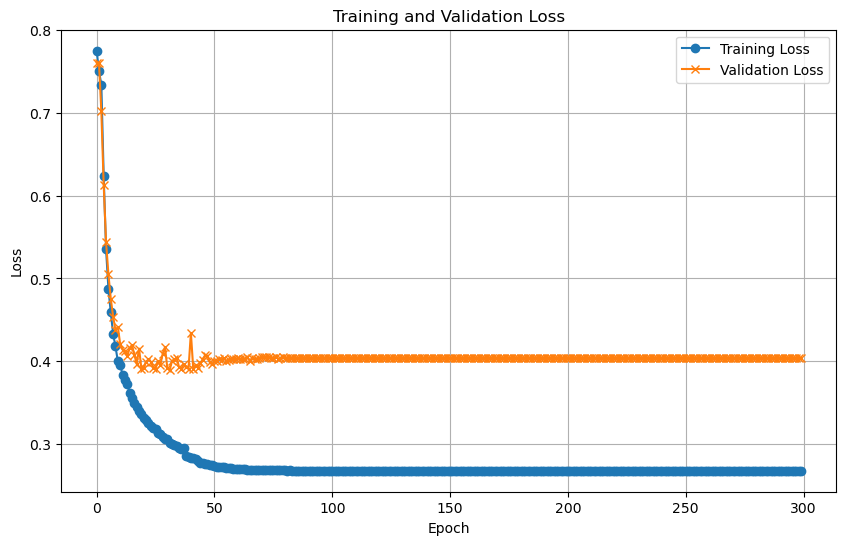

In [8]:
visualize_loss(train_losses, val_losses)